In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import anndata 
import seaborn as sns
from scipy.stats import zscore
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from umap import UMAP

from matplotlib.colors import LinearSegmentedColormap

from scroutines.config_plots import *
from scroutines import powerplots # .config_plots import *
from scroutines import pnmf
from scroutines import basicu


/home/qlyu/mambaforge/envs/bbbroutine/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sample = 'P17NR'
outdir_fig = "/scr/qlyu/projects/v1/figures"

In [3]:
adata = anndata.read(f"../../data/cheng21_cell_scrna/organized/{sample}.h5ad")
genes = adata.var.index.values
adata

AnnData object with n_obs × n_vars = 29153 × 53801
    obs: 'batch', 'n_genes', 'percent_mito', 'n_counts', 'leiden', 'Doublet', 'Doublet Score', 'cluster', 'Class_broad', 'sample', 'Age', 'subclass', 'layer', 'Type', 'Subclass'

In [4]:
adata = adata[adata.obs['Subclass'] == 'L2/3']
types = adata.obs['Type'].values
samps = adata.obs['sample'].values
adata

View of AnnData object with n_obs × n_vars = 5684 × 53801
    obs: 'batch', 'n_genes', 'percent_mito', 'n_counts', 'leiden', 'Doublet', 'Doublet Score', 'cluster', 'Class_broad', 'sample', 'Age', 'subclass', 'layer', 'Type', 'Subclass'

In [5]:
# use those 286 genes
df = pd.read_csv("../../data/cheng21_cell_scrna/res/L23-ABC-genes-n288-n286unq-annot.csv")
genes_sel = df['gene'].astype(str).values
genes_grp = df['P17on'].astype(str).values
assert len(genes_sel) == len(np.unique(genes_sel))

gi = basicu.get_index_from_array(genes, genes_sel)
assert np.all(genes_sel != -1)

# CP10k for single cells
cov = np.array(adata.X.sum(axis=1))
counts = np.array(adata.X[:,gi].todense())
norm = counts/cov*1e4
lognorm = np.log10(norm+1)
zlognorm = zscore(lognorm, axis=0) 

In [6]:
zlognorm = np.nan_to_num(zlognorm, 0)

In [7]:
gene_types, gene_type_counts = np.unique(genes_grp, return_counts=True)
gene_types, gene_type_counts

(array(['A', 'B', 'C'], dtype=object), array([122,  35, 129]))

In [8]:
pca = PCA(n_components=50)
pcs = pca.fit_transform(zlognorm)
ucs = UMAP(n_components=2, n_neighbors=50).fit_transform(pcs)

In [9]:
# fix pc1 to make sure a < c:
pc1 = pcs[:,0]
pc_types, unq_types = basicu.group_mean(pc1.reshape(-1,1), types)
a = pc_types[0,0]
c = pc_types[-1,0]
if a > c:
    pcs[:,0] = -pcs[:,0]

In [10]:
res = pd.DataFrame(pcs, columns=np.char.add("PC", ((1+np.arange(pcs.shape[1])).astype(str))))
res['type'] = types
res['samp'] = samps
res['umap1'] = ucs[:,0]
res['umap2'] = ucs[:,1]

Text(0, 0.5, 'explained var')

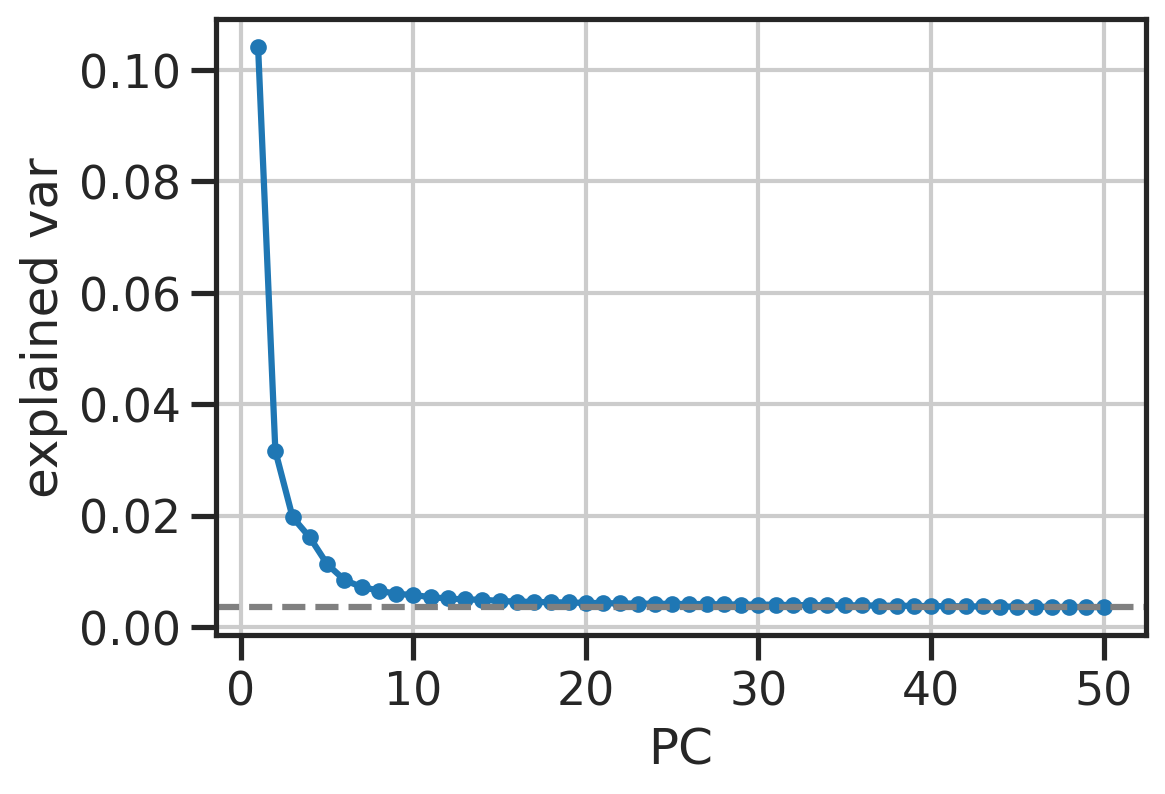

In [11]:
# plt.plot(np.cumsum(pca.explained_variance_ratio_), '-o')
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(np.arange(len(pca.explained_variance_ratio_))+1, pca.explained_variance_ratio_, '-o', markersize=5)
ax.axhline(1/lognorm.shape[1], linestyle='--', color='gray')
ax.set_xlabel('PC')
ax.set_ylabel('explained var')

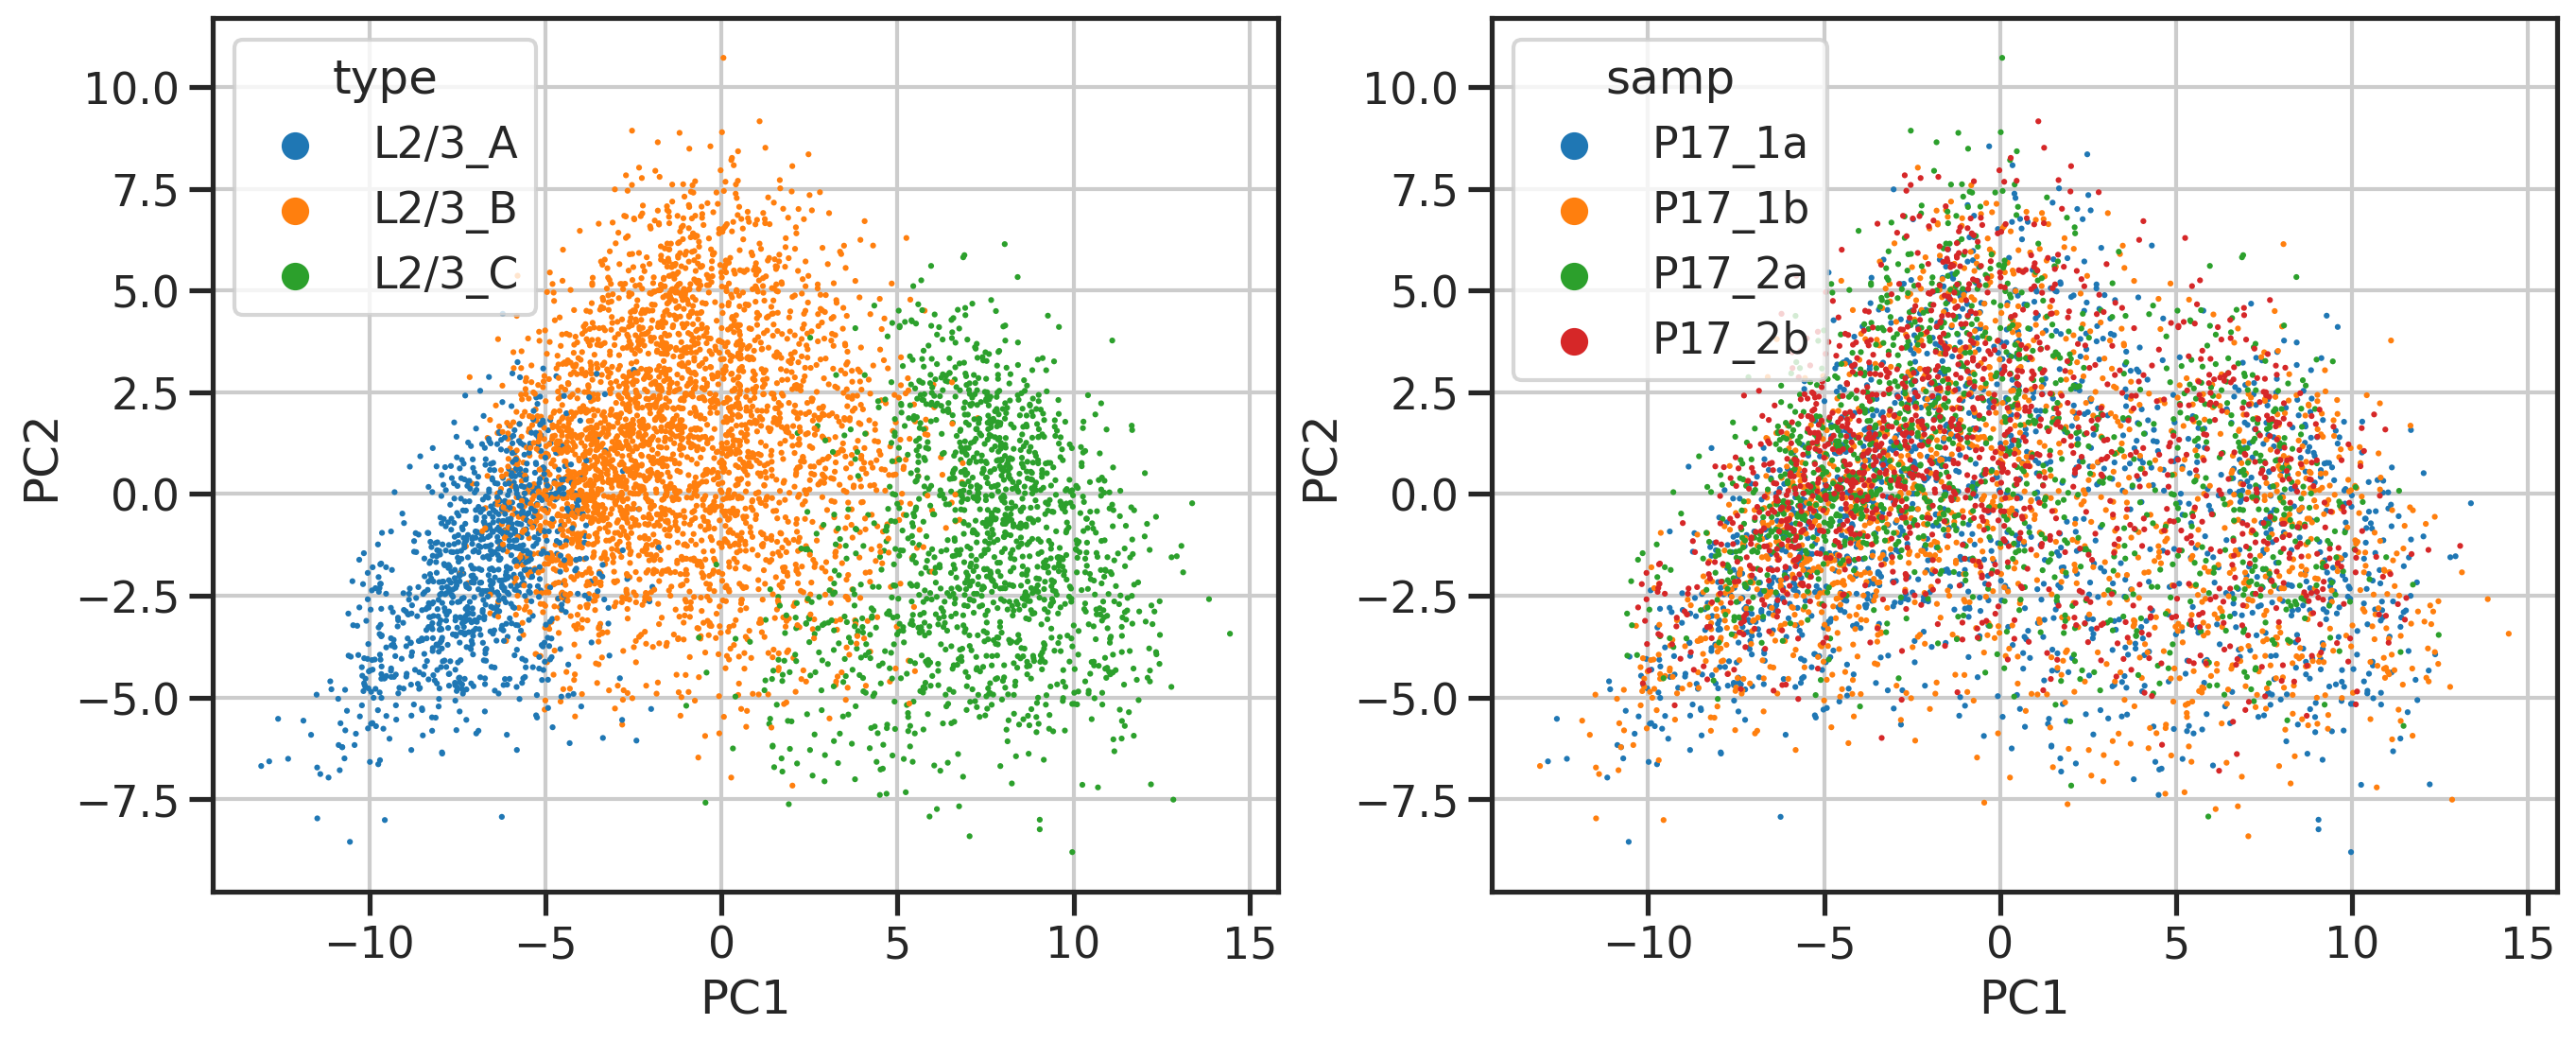

In [12]:
fig, axs = plt.subplots(1,2,figsize=(8*2,6))
ax = axs[0]
sns.scatterplot(data=res, x='PC1', y='PC2', 
                hue='type',
                s=5, edgecolor='none', 
                ax=ax,
               )
ax = axs[1]
sns.scatterplot(data=res, x='PC1', y='PC2', 
                hue='samp',
                s=5, edgecolor='none', 
                ax=ax,
               )
plt.show()

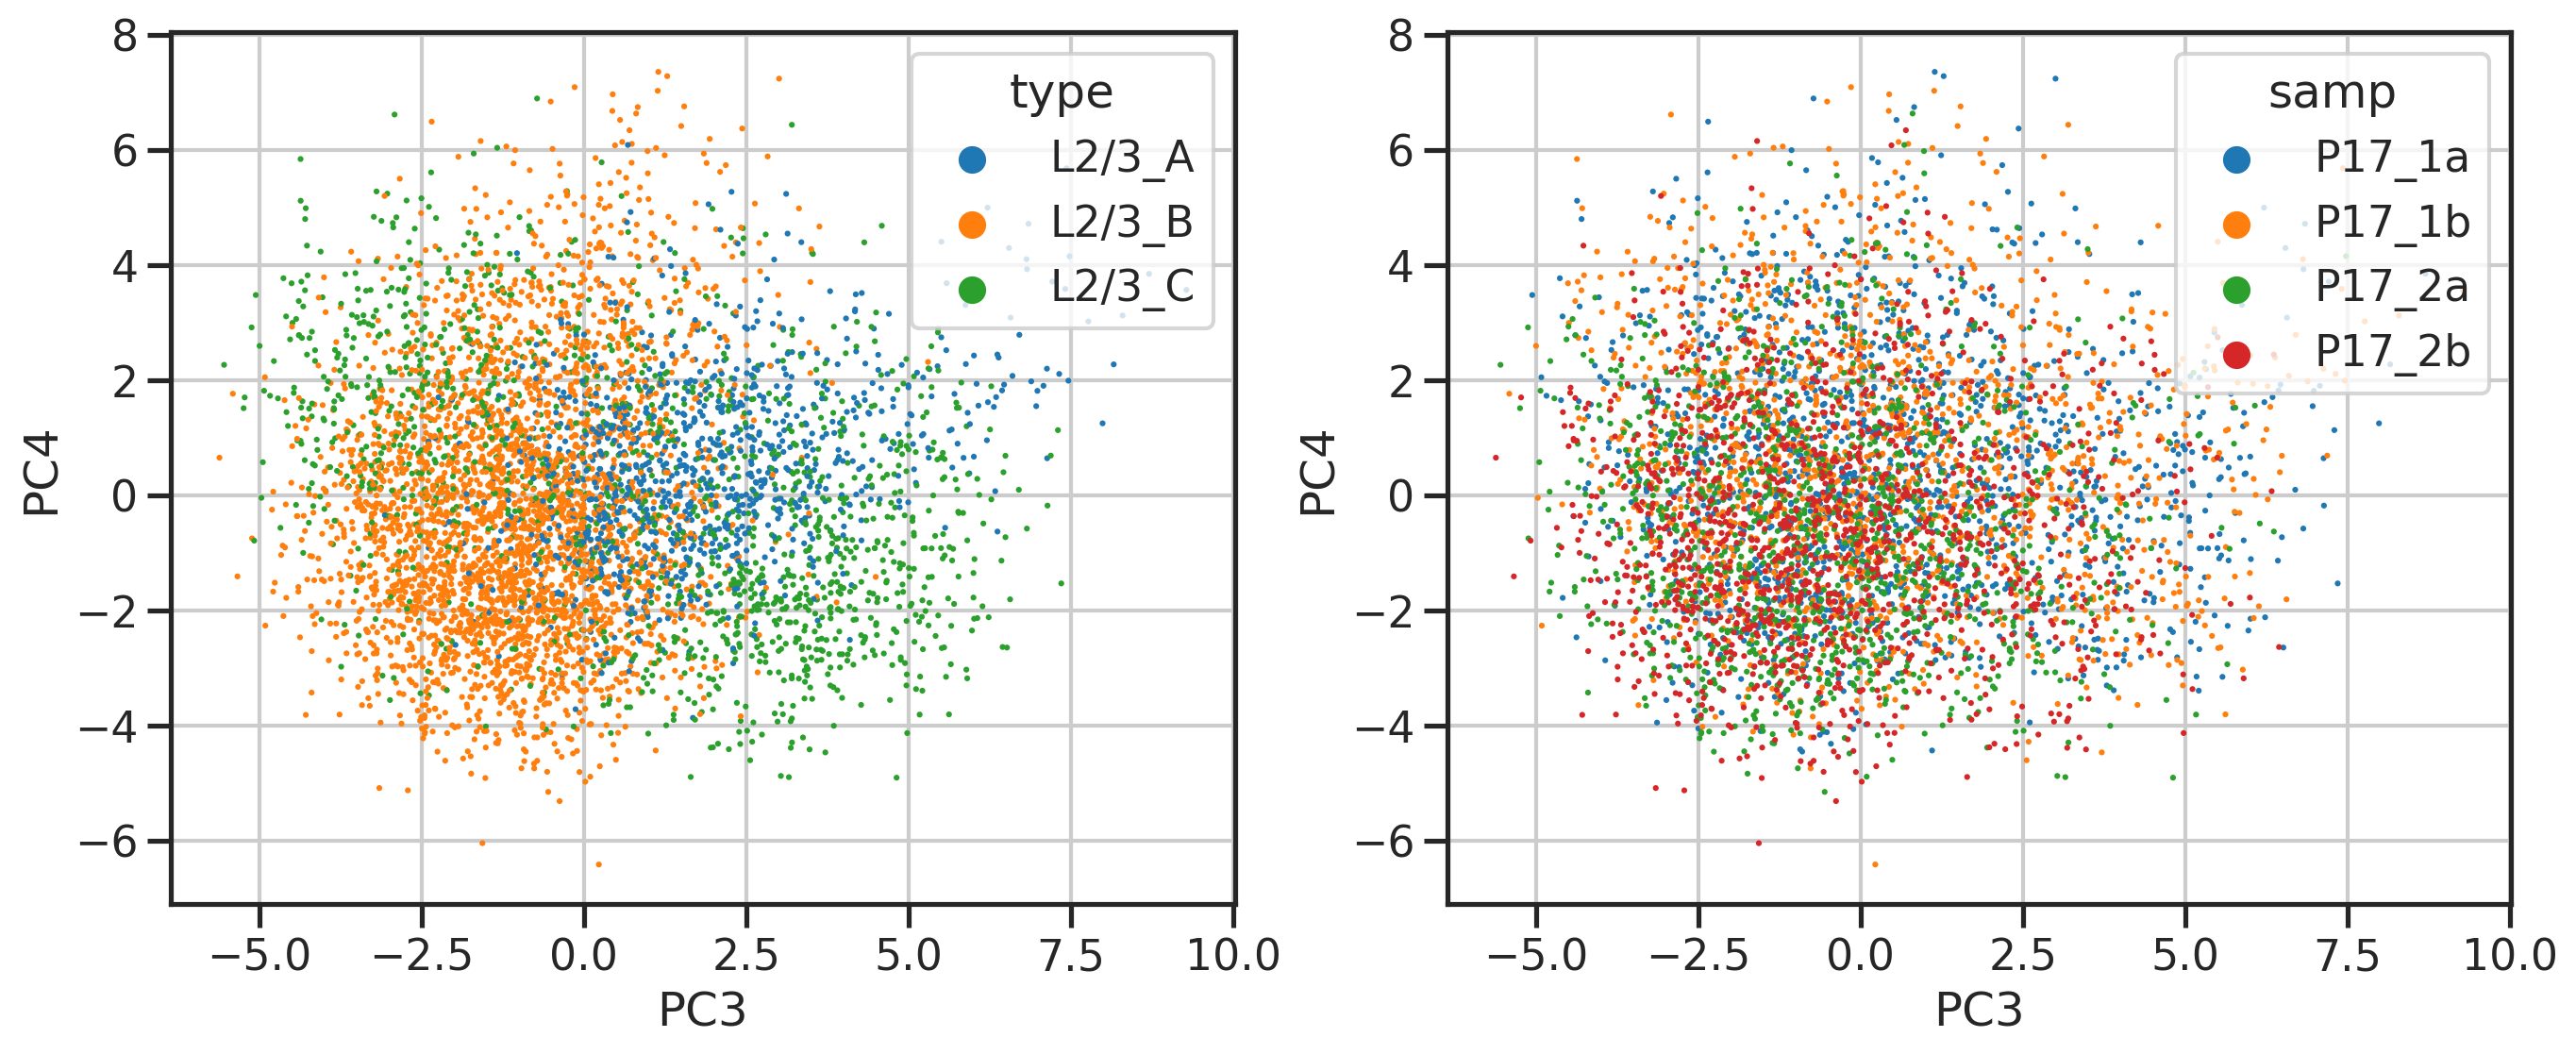

In [13]:
fig, axs = plt.subplots(1,2,figsize=(8*2,6))
ax = axs[0]
sns.scatterplot(data=res, x='PC3', y='PC4', 
                hue='type',
                s=5, edgecolor='none', 
                ax=ax,
               )
ax = axs[1]
sns.scatterplot(data=res, x='PC3', y='PC4', 
                hue='samp',
                s=5, edgecolor='none', 
                ax=ax,
               )
plt.show()

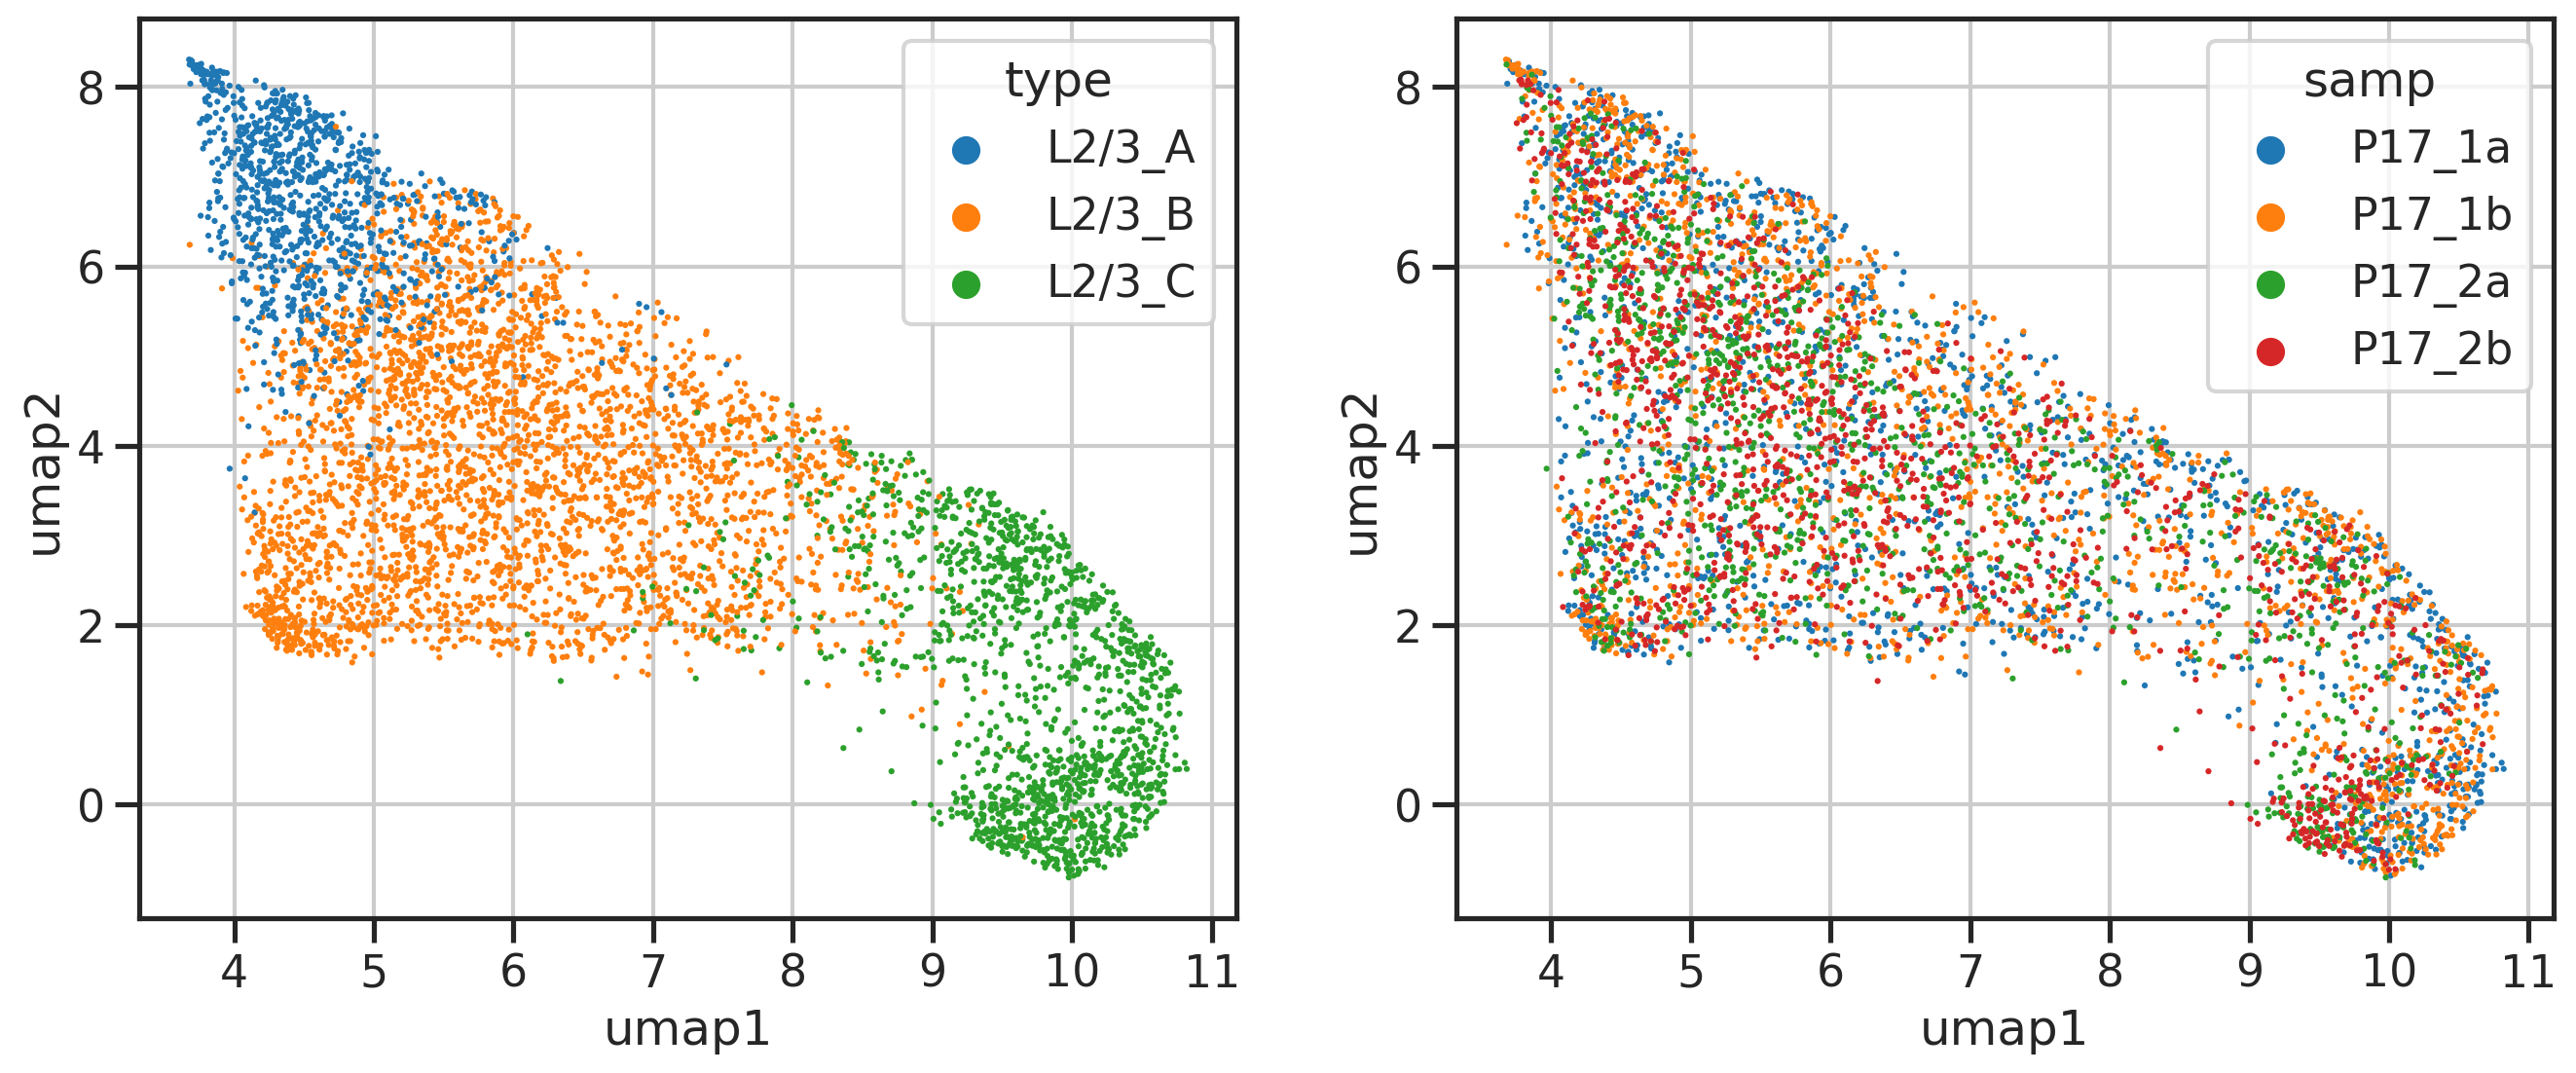

In [14]:
fig, axs = plt.subplots(1,2,figsize=(8*2,6))
ax = axs[0]
sns.scatterplot(data=res, x='umap1', y='umap2', 
                hue='type',
                s=5, edgecolor='none', 
                ax=ax,
               )
ax = axs[1]
sns.scatterplot(data=res, x='umap1', y='umap2', 
                hue='samp',
                s=5, edgecolor='none', 
                ax=ax,
               )
plt.show()

# heatmap

In [15]:
choices1 = sns.color_palette('tab10', 3)
choices1

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313)]

In [16]:
choices2 = sns.color_palette('tab20', 20)
choices2

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (0.6823529411764706, 0.7803921568627451, 0.9098039215686274),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (1.0, 0.7333333333333333, 0.47058823529411764),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.596078431372549, 0.8745098039215686, 0.5411764705882353),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (1.0, 0.596078431372549, 0.5882352941176471),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.7725490196078432, 0.6901960784313725, 0.8352941176470589),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.7686274509803922, 0.611764705882353, 0.5803921568627451),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.9686274509803922, 0.7137254901960784, 0.8235294117647058),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7803921568627451, 0.7803921568627451, 0.7803921568627451),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.8588235294117647, 0.8588235294117647, 0.5529411764705883),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
 (0.6196078431372549, 0.8549019607843137, 0.8980392156862745)]

In [17]:
my_colors = tuple(list(choices1)) #('C0', 'C1', 'C2')
cmap_d1 = LinearSegmentedColormap.from_list('', my_colors, len(my_colors))

my_colors = tuple(list(choices2[6:8])+list(choices2[14:16]))
cmap_d2 = LinearSegmentedColormap.from_list('', my_colors, len(my_colors))

ncell, ngene = zlognorm.shape

In [18]:
adata.obsm['X_pca'] = pcs
sc.pp.neighbors(adata, n_neighbors=50, use_rep='X_pca')
sc.tl.diffmap(adata)
adata.uns['iroot'] = np.argmin(pcs[:,0])
sc.tl.dpt(adata)
res['ptime'] = adata.obs['dpt_pseudotime'].values

In [19]:
cellidx = np.argsort(res['ptime'].values)

# # gene ptime
# weights = ((lognorm+1e-10)/(lognorm.sum(axis=0)+1e-10))
# gptime  = res['ptime'].values.dot(weights)
# geneidx = np.argsort(gptime)

# Use P28 ordering
f = '../../results/gene_ptime_P28_L23_Mar27.tsv'
gpt = pd.read_csv(f)
gpt = gpt['gene_ptime'].values
geneidx2 = np.argsort(gpt)

# check pseudotime (and diff map)

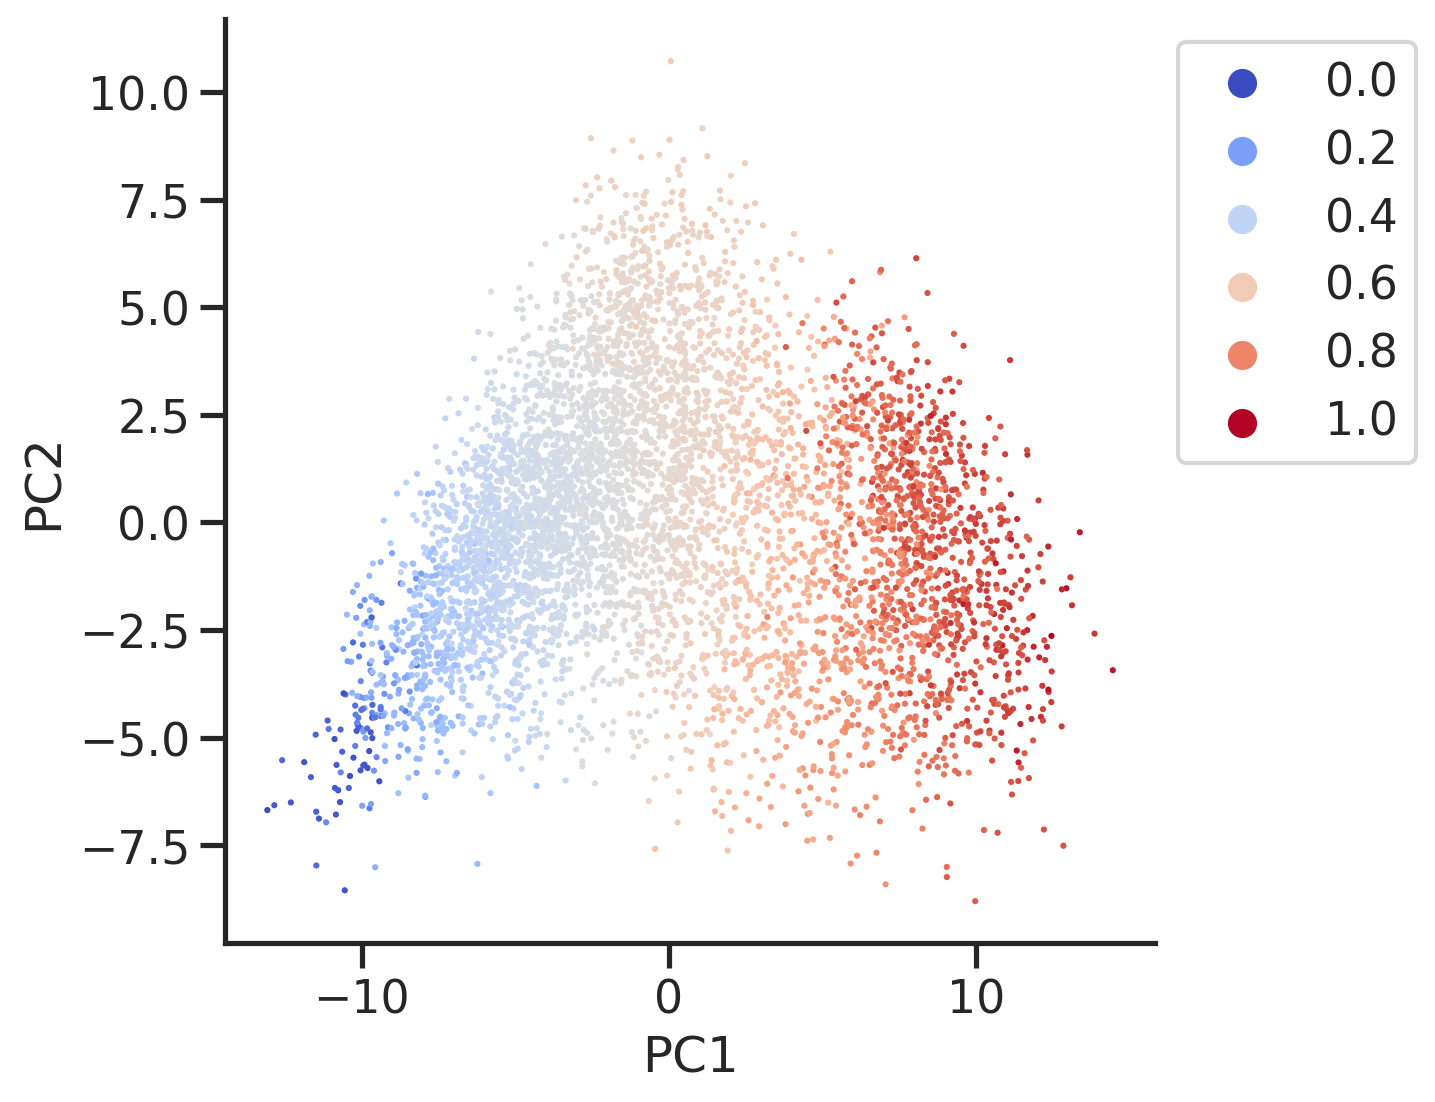

In [20]:
fig, ax = plt.subplots(figsize=(6,6))
sns.scatterplot(data=res, 
                x='PC1',
                y='PC2',
                hue='ptime',
                # hue_order=np.sort(adata.obs['cluster'].unique()),
                edgecolor='none',
                s=5,
                ax=ax,
                palette='coolwarm',
               )
# ax.set_xlabel(f'PC1 ({pca_v[0]*100:.1f}% var)')
# ax.set_ylabel(f'PC2 ({pca_v[1]*100:.1f}% var)')

ax.legend(bbox_to_anchor=(1,1), loc='upper left')
sns.despine(ax=ax)
ax.grid(False)
# powerplots.savefig_autodate(fig, os.path.join(fig_dir, 'easifish_pca_proj.pdf'))
plt.show()

03-28 14:04:58 - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


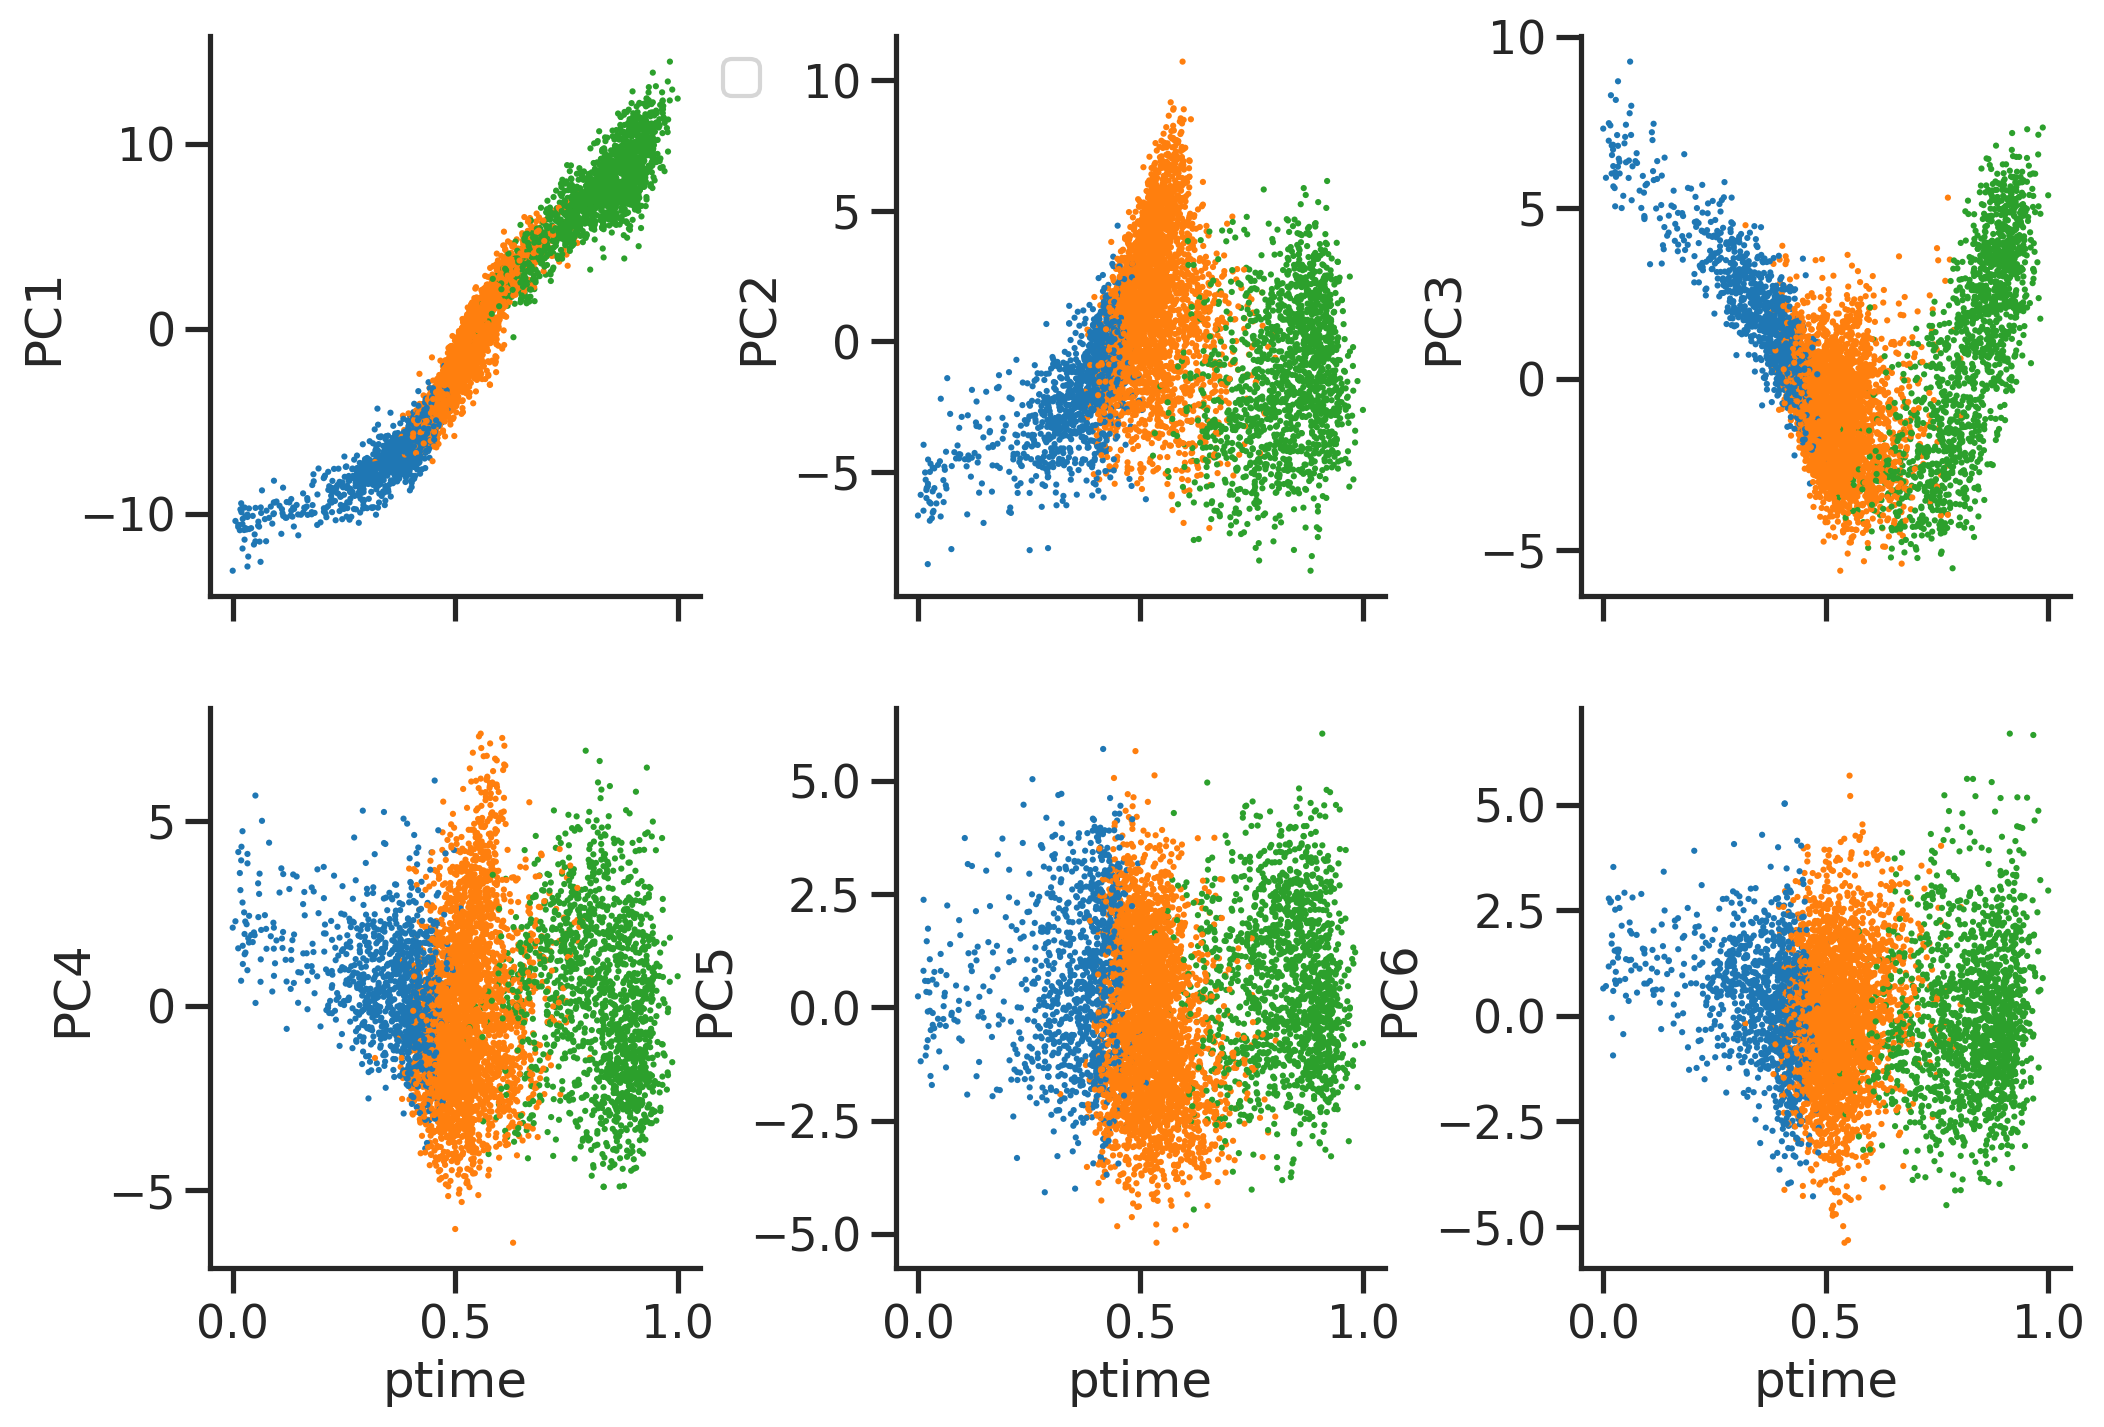

In [21]:
fig, axs = plt.subplots(2, 3, figsize=(4*3,4*2), sharex=True)
for i, ax in enumerate(axs.flat):
    sns.scatterplot(data=res, 
                    x='ptime',
                    y=f'PC{i+1}',
                    hue='type',
                    edgecolor='none',
                    s=5,
                    ax=ax,
                    legend=False,
                   )
    ax.grid(False)
    sns.despine(ax=ax)
axs.flat[0].legend(bbox_to_anchor=(1,1), loc='upper left')
# powerplots.savefig_autodate(fig, os.path.join(fig_dir, 'easifish_pca_proj.pdf'))
fig.subplots_adjust(wspace=0.4)
plt.show()

03-28 14:05:05 - maxp pruned
03-28 14:05:05 - cmap pruned
03-28 14:05:05 - kern dropped
03-28 14:05:05 - post pruned
03-28 14:05:05 - FFTM dropped
03-28 14:05:05 - GPOS pruned
03-28 14:05:05 - GSUB pruned
03-28 14:05:05 - name pruned
03-28 14:05:05 - glyf pruned
03-28 14:05:05 - Added gid0 to subset
03-28 14:05:05 - Added first four glyphs to subset
03-28 14:05:05 - Closing glyph list over 'GSUB': 35 glyphs before
03-28 14:05:05 - Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'G', 'N', 'P', 'R', 'a', 'c', 'e', 'five', 'four', 'g', 'k', 'l', 'm', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'seven', 'space', 't', 'three', 'two', 'y', 'z', 'zero']
03-28 14:05:05 - Glyph IDs:   [0, 1, 2, 3, 17, 19, 20, 21, 22, 23, 24, 26, 36, 37, 38, 42, 49, 51, 53, 68, 70, 72, 74, 78, 79, 80, 81, 82, 83, 85, 86, 87, 92, 93, 3228]
03-28 14:05:05 - Closed glyph list over 'GSUB': 35 glyphs after
03-28 14:05:05 - Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'G', 'N', 'P', 'R'

saved the figure to: /scr/qlyu/projects/v1/figures/heatmap_P17NR_v4_2023-03-28.pdf


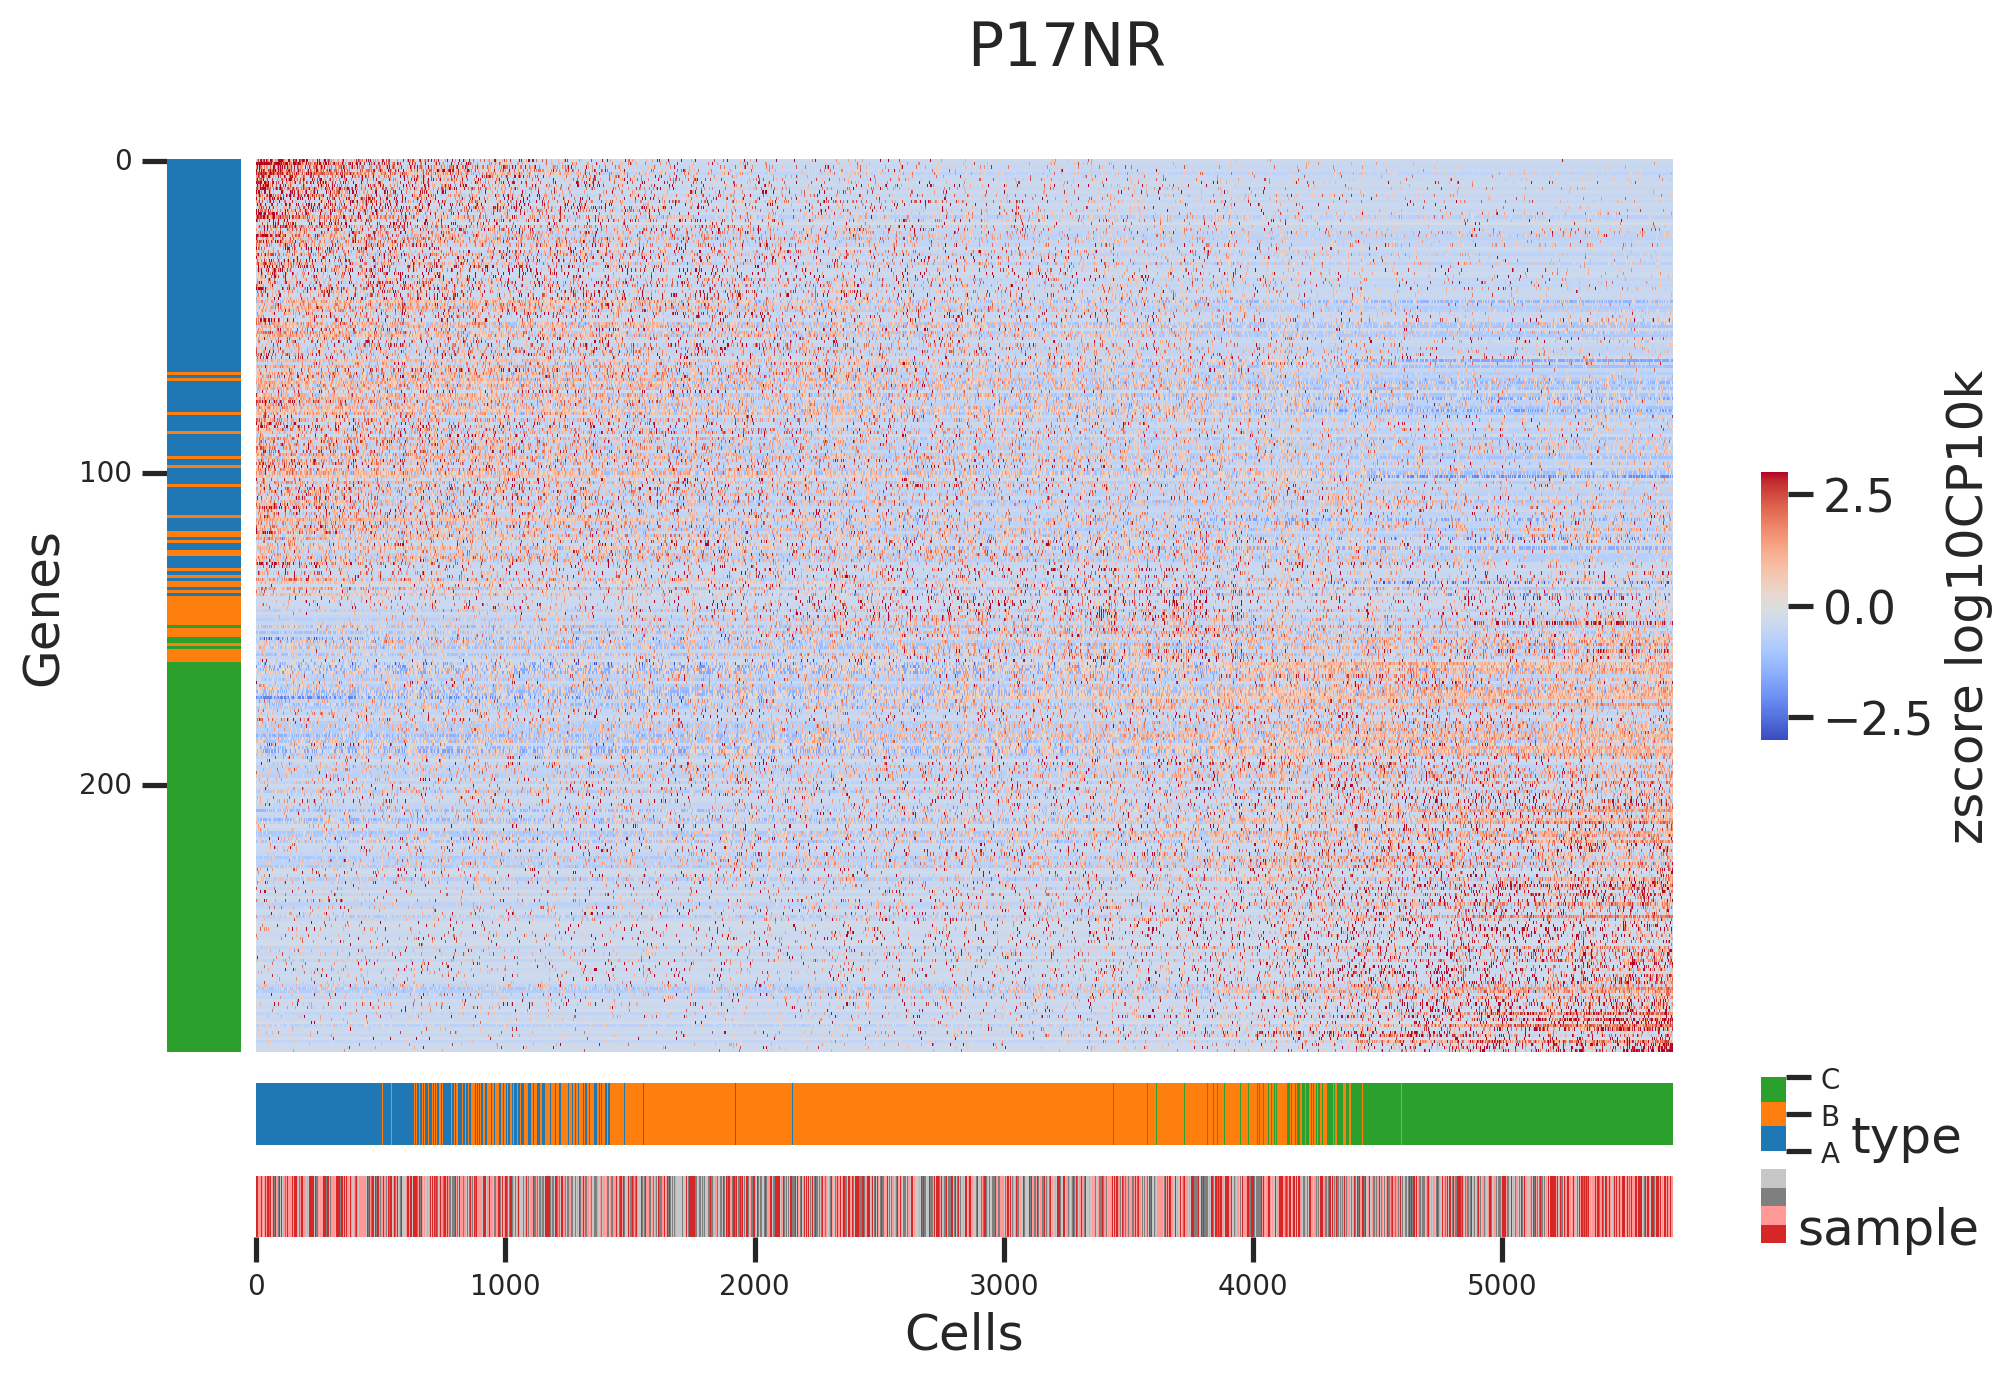

In [22]:

mosaic = ("B"+"A"*20+"\n")*10 + ("."+"C"*20+"\n") + ("."+"D"*20+"\n")
# print(mosaic)

fig, axdict = plt.subplot_mosaic(mosaic, figsize=(12,7))
ax = axdict['A']
sns.heatmap(zlognorm[cellidx][:,geneidx2].T,
            xticklabels=False,
            yticklabels=False,
            cbar_kws=dict(shrink=0.3, label='zscore log10CP10k', aspect=10),
            center=0,
            vmax=3,
            vmin=-3,
            cmap='coolwarm',
            rasterized=True,
            ax=ax,
           )

ax = axdict['B']
sns.heatmap(pd.factorize(genes_grp[geneidx2], sort=True)[0].reshape(-1,1), 
            xticklabels=False,
            yticklabels=100,
            cmap=cmap_d1,
            cbar=False,
            rasterized=True,
            ax=ax, 
           )
ax.set_ylabel('Genes')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=10)

ax = axdict['C']
sns.heatmap(pd.factorize(types[cellidx], sort=True)[0].reshape(-1,1).T, 
            xticklabels=False,
            yticklabels=False,
            cmap=cmap_d1,
            cbar_kws=dict(ticks=[0,1,2], shrink=1.2, aspect=3, label='type'),
            rasterized=True,
            ax=ax, 
           )
fig.axes[-1].set_yticklabels(['A','B','C'], fontsize=10)
fig.axes[-1].set_ylabel(fig.axes[-1].get_ylabel(), rotation=0, ha='left')

ax = axdict['D']
sns.heatmap(pd.factorize(samps[cellidx], sort=True)[0].reshape(-1,1).T, 
            xticklabels=1000,
            yticklabels=False,
            cmap=cmap_d2,
            cbar_kws=dict(ticks=[], shrink=1.2, aspect=3, label='sample'),
            rasterized=True,
            ax=ax, 
           )
ax.set_xlabel('Cells')
fig.axes[-1].set_ylabel(fig.axes[-1].get_ylabel(), rotation=0, ha='left')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=10)

fig.subplots_adjust(hspace=0.5)
fig.suptitle(sample)
powerplots.savefig_autodate(fig, os.path.join(outdir_fig, f'heatmap_{sample}_v4.pdf'))
plt.show()

In [23]:
# save ptime info

In [24]:
res.index = adata.obs.index
res

PC1       PC2       PC3       PC4  \
AAACCCATCGAAATCC-1-P17_1a-P17  -3.178389 -0.764597 -1.205187  0.253088   
AAACGAACAGTCCGTG-1-P17_1a-P17   2.085440  4.877945  0.312075  3.311954   
AAAGAACTCTCTGAGA-1-P17_1a-P17  -5.181047  0.010815  0.143720 -1.273174   
AAAGGATAGCTGACAG-1-P17_1a-P17  -2.134230  2.339902  0.423802 -1.602676   
AAAGGATAGTTGCTCA-1-P17_1a-P17  10.402589 -0.836603  6.430594 -1.135853   
...                                  ...       ...       ...       ...   
TTTGATCAGGTCACCC-1-P17_2b-P17  -4.976694  1.176079 -0.656773 -0.398295   
TTTGGTTCAGCAATTC-1-P17_2b-P17   2.308354  5.277859 -0.363459 -2.857872   
TTTGGTTGTTCCTAAG-1-P17_2b-P17  -6.087092 -4.682531  0.627334  1.171371   
TTTGTTGAGGCTAGCA-1-P17_2b-P17   7.756651  0.611754  3.400439 -3.044742   
TTTGTTGTCGGTCTAA-1-P17_2b-P17   3.693498 -0.757159 -3.549173 -1.852954   

                                    PC5       PC6       PC7       PC8  \
AAACCCATCGAAATCC-1-P17_1a-P17 -1.744762  1.383254 -0.354550  0.436666   
AAACGAACAGTCCGTG-1-P17_1a-P17 -1.306549 -0.830194  0.772553  2.353299   
AAAGAACTCTCTGAGA-1-P17_1a-P17 -1.178423  0.315538 -1.364218 -2.196558   
AAAGGATAGCTGACAG-1-P17_1a-P17 -2.100692 -0.495270  1.084420 -1.198159   
AAAGGATAGTTGCTCA-1-P17_1a-P17 -1.148919 -1.516099 -1.894134  0.021482   
...                                 ...       ...       ...       ...   
TTTGATCAGGTCACCC-1-P17_2b-P17  2.100080 -0.889990  0.514475  0.378584   
TTTGGTTCAGCAATTC-1-P17_2b-P17 -0.307806  0.275530  0.604757 -0.711588   
TTTGGTTGTTCCTAAG-1-P17_2b-P17  0.406145  1.436722  0.325597  1.986820   
TTTGTTGAGGCTAGCA-1-P17_2b-P17  3.783378 -1.155943  0.114421 -2.212418   
TTTGTTGTCGGTCTAA-1-P17_2b-P17  2.631033  2.980470  0.247522  0.084971   

                                    PC9      PC10  ...      PC46      PC47  \
AAACCCATCGAAATCC-1-P17_1a-P17  0.117403 -0.752294  ... -0.488160  1.141335   
AAACGAACAGTCCGTG-1-P17_1a-P17 -0.168697  0.453409  ...  0.088012  0.022528   
AAAGAACTCTCTGAGA-1-P17_1a-P17  0.673532 -1.543985  ... -0.230980 -0.062482   
AAAGGATAGCTGACAG-1-P17_1a-P17  1.894786 -1.395416  ...  0.648770  1.810365   
AAAGGATAGTTGCTCA-1-P17_1a-P17  0.713028  1.726572  ...  0.619285 -0.482993   
...                                 ...       ...  ...       ...       ...   
TTTGATCAGGTCACCC-1-P17_2b-P17  0.411609 -0.731616  ... -0.990954  0.741661   
TTTGGTTCAGCAATTC-1-P17_2b-P17 -2.855910 -0.681351  ... -0.643916 -0.378720   
TTTGGTTGTTCCTAAG-1-P17_2b-P17  1.105694  2.015591  ... -2.056364 -1.303555   
TTTGTTGAGGCTAGCA-1-P17_2b-P17 -0.813921  0.629260  ... -0.499419  1.246293   
TTTGTTGTCGGTCTAA-1-P17_2b-P17  0.070955  0.090779  ... -1.087110  1.725321   

                                   PC48      PC49      PC50    type    samp  \
AAACCCATCGAAATCC-1-P17_1a-P17 -0.313704 -0.437881  0.482475  L2/3_B  P17_1a   
AAACGAACAGTCCGTG-1-P17_1a-P17  0.272151  0.215745  0.674423  L2/3_B  P17_1a   
AAAGAACTCTCTGAGA-1-P17_1a-P17 -1.017538 -1.123250 -0.271773  L2/3_B  P17_1a   
AAAGGATAGCTGACAG-1-P17_1a-P17  0.460094  1.057988 -1.012547  L2/3_B  P17_1a   
AAAGGATAGTTGCTCA-1-P17_1a-P17 -0.286259  0.856563 -0.196366  L2/3_C  P17_1a   
...                                 ...       ...       ...     ...     ...   
TTTGATCAGGTCACCC-1-P17_2b-P17  1.208823  0.727670 -1.863827  L2/3_B  P17_2b   
TTTGGTTCAGCAATTC-1-P17_2b-P17 -2.899473  1.325525  0.593313  L2/3_B  P17_2b   
TTTGGTTGTTCCTAAG-1-P17_2b-P17 -0.597405  1.229103  0.907294  L2/3_A  P17_2b   
TTTGTTGAGGCTAGCA-1-P17_2b-P17 -0.575814 -0.019274  0.148470  L2/3_C  P17_2b   
TTTGTTGTCGGTCTAA-1-P17_2b-P17 -2.706288  0.159948 -0.699589  L2/3_B  P17_2b   

                                   umap1     umap2     ptime  
AAACCCATCGAAATCC-1-P17_1a-P17   5.681152  5.467414  0.458667  
AAACGAACAGTCCGTG-1-P17_1a-P17   4.930157  1.745472  0.588728  
AAAGAACTCTCTGAGA-1-P17_1a-P17   5.293082  6.208891  0.430882  
AAAGGATAGCTGACAG-1-P17_1a-P17   5.090416  4.437601  0.489171  
AAAGGATAGTTGCTCA-1-P17_1a-P17  10.196587 -0.083607  0.865722  
...    

In [25]:
fout = f"/scr/qlyu/projects/v1/results/cell_ptime_{sample}_L23_Mar28.tsv"
res.index = adata.obs.index
res.to_csv(fout, header=True, index=True)